### Two options for now:
1. Follow strictly on original Grad-CAM: gradient back to last conv feature map, and then resize to the original image space.
2. Backprop all the way back to the input image: but the original image object is already updated through backward, this is a very special case. Since for get_activation function for any other layers, we can just do a forward pass again. cloning doesn't work since backprop will apply to both original and cloned tensor.


In [49]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2
import requests
import json
import os
from PIL import Image

In [50]:
# Global Path Vairables
ROOT_DIR =  "drive/MyDrive/11877-AMMML/dataset/random/images/"
DATASET_DIR = ROOT_DIR + "classes"

# Load imagenet classes
with open(ROOT_DIR + "imagenet1000_clsidx_to_labels.txt") as f:
    idx2label = eval(f.read())

In [51]:
def get_all_files_from_dir(directory):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        file_paths += [os.path.join(root, x) for x in files]
    return sorted(file_paths)

In [62]:
class ImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        super(ImageDataset, self).__init__()
        self.image_paths = get_all_files_from_dir(image_folder)
        self.transform = transform
        self.idx_to_path = {i: image_path for i, image_path in enumerate(self.image_paths)}
        self.path_to_index = {image_path: i for i, image_path in enumerate(self.image_paths)}


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image_filepath = self.idx_to_path[idx]
        image = Image.open(image_filepath)
        if self.transform:
          image = self.transform(image)
        return image, image_filepath
    
    def get_by_path(self, path):
      image, _ =  self.__getitem__(self.path_to_index[path])
      image = image[None, :]
      return image

In [63]:
# use the ImageNet transformation
imagenet_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

# define a 1 image dataset
# dataset = datasets.ImageFolder(root=DATASET_DIR, transform=transform)
dataset = ImageDataset(DATASET_DIR, imagenet_transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=True, batch_size=1)

In [64]:
class VGGExplain(nn.Module):
    def __init__(self, visualization):
        super(VGGExplain, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None

        self.visualization = visualization # raw or gradcam

        self.raw_input = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        self.raw_input = x.clone().detach().cpu().numpy()
        if self.visualization == "raw":
          x.requires_grad = True
          h = x.register_hook(self.activations_hook)
        x = self.features_conv(x)
        
        if self.visualization == "gradcam":
          h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        if self.visualization == "gradcam":
          return self.features_conv(x)
        elif self.visualization == "raw":
          return self.raw_input
        else:
          return None

    def get_raw_input(self):
      return self.raw_input

In [66]:
# You can randomly walk the dataloader, or specify a concrete image path
# img, image_path = next(iter(dataloader))
# image_path = image_path[0] # for batch

image_path = "drive/MyDrive/11877-AMMML/dataset/random/images/classes/cat/zhengjing.jpg"
# img = dataset.get_by_path(image_path)

In [ ]:
# def vision_visualize(image_path, explain_model_class, visualization, checkpoint=None):
#   img = dataset.get_by_path(image_path)
#   # initialize the VGG model and set the evaluation mode
# vgg = VGGExplain()
# vgg.eval()

# # get the most likely prediction of the model
# pred = vgg(img)
# index = pred.argmax(dim=1).numpy()[0]




In [68]:
# initialize the VGG model and set the evaluation mode
vgg = VGGExplain()
vgg.eval()

# get the most likely prediction of the model
pred = vgg(img)
index = pred.argmax(dim=1).numpy()[0]

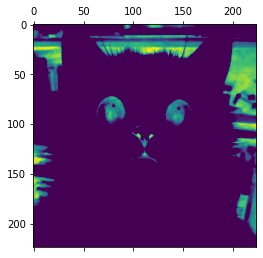

In [69]:
# pull the gradients out of the model
pred[:, index].backward()

gradients = vgg.get_activations_gradient()

# pool the gradients across the channels, so that each channel have one gradient value
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
pooled_gradients_np = pooled_gradients.detach().cpu().numpy()

# get the activations of the last convolutional layer
# activations = vgg.get_activations(img).detach()
raw_activations = vgg.get_activations(img)
activations = np.zeros(raw_activations.shape)

# weight the channels by corresponding gradients
for i in range(activations[0].shape[0]):
    activations[:, i, :, :] = raw_activations[:, i, :, :] * pooled_gradients_np[i]
    
# average the channels of the activations
heatmap = torch.mean(torch.from_numpy(activations), axis=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

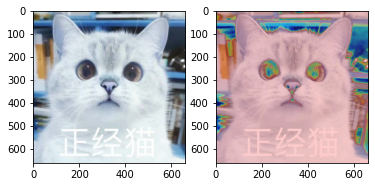

Predicted index is 287 and predicted class is lynx, catamount
Darker-color heatmap indicate strong correlation between the region and predicted class


In [71]:
plot_image = cv2.imread(image_path)
updated_heatmap = cv2.resize(np.array(heatmap), (plot_image.shape[1], plot_image.shape[0]))
updated_heatmap = np.uint8(255 * updated_heatmap)
updated_heatmap = cv2.applyColorMap(updated_heatmap, cv2.COLORMAP_JET)
superimposed_img = updated_heatmap *0.5 + plot_image

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(plot_image)
f.add_subplot(1, 2, 2)
plt.imshow(superimposed_img / np.max(superimposed_img))
plt.show(block=True)

print("Predicted index is", index, "and predicted class is", idx2label[index])
print("Darker-color heatmap indicate strong correlation between the region and predicted class")